In [1]:
import nltk
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re, string, os

lem = nltk.stem.WordNetLemmatizer()
stopwords = nltk.corpus.stopwords.words("english")

In [2]:
# https://www.bbc.com/news/world-europe-60674333
bbc_article = """
Ukraine's First Lady Olena Zelenska has issued an impassioned statement on the Russian invasion, condemning the "mass murder" of the country's civilians.
She focused on child casualties, mentioning the names of three children who had died in the bombardments.
She said Ukraine wanted peace but would defend its borders and its identity.
The whereabouts of Mrs Zelenska, 44, are unknown, and her husband President Volodymyr Zelensky says his family is a target for Russian forces.
In an open letter published on the Ukrainian president's website late on Tuesday in English, International Women's Day, Mrs Zelenska said she had received numerous requests for interviews and that her letter served as an answer.
She said the invasion was "impossible to believe. Our country was peaceful; our cities, towns and villages were full of life".
"It is, in fact, the mass murder of Ukrainian civilians," she added, despite Russian efforts to portray it as a "special operation".
"Perhaps the most terrifying and devastating of this invasion are the child casualties.
"Eight-year-old Alice who died on the streets of Okhtyrka while her grandfather tried to protect her. Or Polina from Kyiv, who died in the shelling with her parents.
"Fourteen-year-old Arseniy was hit in the head by wreckage, and could not be saved because an ambulance could not get to him on time because of intense fires.
"When Russia says that it is 'not waging war against civilians', I call out the names of these murdered children first."
Mrs Zelenska said there were now several dozen children born in recent weeks who had never known peace.
But she said Russian President Vladimir Putin had underestimated Ukraine, its people and its patriotism.
"While Kremlin propagandists bragged that Ukrainians would welcome them with flowers as saviours, they have been shunned with Molotov cocktails," she added.
She also thanked people around the world for their support, and called on the West to "close the sky, and we will manage the war on the ground ourselves".
The first lady ended with a plea to media to "keep showing the truth".
"If we don't stop Putin, who threatens to start a nuclear war, there will be no safe place in the world for any of us. We will win. Because of our unity. Unity towards love for Ukraine."
"""
cnn_article = """
As recently as the 2008 global financial crisis, Russian President Vladimir Putin and his lieutenants had promoted the ruble as a potential alternative to the US dollar, arguing that it should be an integral part of the global financial system. Russia would become one of the world's five biggest economies, they claimed.
Putin's quest to dominate his neighbors, starting with his assault on Georgia in 2008, and continuing with the annexation of Crimea in 2014 and last month's invasion of Ukraine, has shredded what remained of the authoritarian leader's economic dreams.
In early 2008, one US dollar would buy roughly 25 rubles. The Russian currency has depreciated significantly since then, and Western sanctions imposed in response to the invasion of Ukraine have pushed it into freefall. On Wednesday, one US dollar could buy 117 rubles in Moscow after the currency fell 10% and hit a new record low. The ruble has been even weaker in the offshore market this week.
The latest slide came after Russia's central bank banned Russians from buying hard currencies and ordered banks to cap withdrawals from foreign currency accounts at $10,000 for the next six months, moves that could help preserve some of the country's dollar reserves and support the ruble.
Sergey Aleksashenko, a former Russian finance ministry and central bank official, described the strategy as "incredible foolishness" that could lead to a run on the banks.
"Apparently, the outflow of foreign currency deposits from Russian banks has exceeded the Bank of Russia's forecasts and put under question the banks' ability to meet their obligations," he wrote in a newsletter.
"The biggest mistake monetary authority may make in Russia is to touch private savings — if there was no bank run until now, it's going to happen," added Aleksashenko.
Russia has been scrambling to prevent financial meltdown since the United States, European Union and other Western allies imposed sanctions on much of the country's banking system, including freezing hundreds of billions of dollars worth of reserves Moscow had been stockpiling for years to shield the economy. Analysts estimate that more than half of Russia's reserves of foreign currency and gold are now off limits.
The central bank more than doubled interest rates to 20%, and temporarily banned Russian brokers from selling securities held by foreigners. The government has ordered exporters to exchange 80% of their foreign currency revenues for rubles, and banned Russian residents from making bank transfers outside Russia.
The ruble has come under intense pressure, and Moscow's failure to defend the currency will translate to economic pain. Russia is a leading exporter of oil and gas but many other sectors of its economy rely on imports. As the value of the ruble falls, they will become much more expensive to buy, pushing up inflation.
Fitch Ratings slashed Russia's credit rating on Tuesday and warned that a default was "imminent."
"The further ratcheting up of sanctions, and proposals that could limit trade in energy, increase the probability of a policy response by Russia that includes at least selective non-payment of its sovereign debt obligations," the ratings agency said in a statement.
Even with Russia on the brink of default, Western countries are continuing to unleash punishing restrictions designed to further isolate Moscow. The United States and the United Kingdom banned Russian energy imports on Tuesday, and the European Union said it would attempt to reduce natural gas imports by 66% this year.
For Moscow, the costs are adding up. The central bank's decision to prevent Russians from buying US dollars marks the end of the ruble, according to Anders Åslund, an economist and former adviser to the Russian government.
"""
def flatten(t):
    return [item for sub in t for item in sub]
dataset = [bbc_article, cnn_article]

In [3]:
chunker=nltk.data.load(nltk.chunk._MULTICLASS_NE_CHUNKER) # cf. nltk/chunk/__init__.py
sorted(chunker._tagger._classifier.labels())

['B-FACILITY',
 'B-GPE',
 'B-GSP',
 'B-LOCATION',
 'B-ORGANIZATION',
 'B-PERSON',
 'I-FACILITY',
 'I-GPE',
 'I-GSP',
 'I-LOCATION',
 'I-ORGANIZATION',
 'I-PERSON',
 'O']

In [4]:
import spacy

In [6]:
nlp = spacy.load("en_core_web_sm")

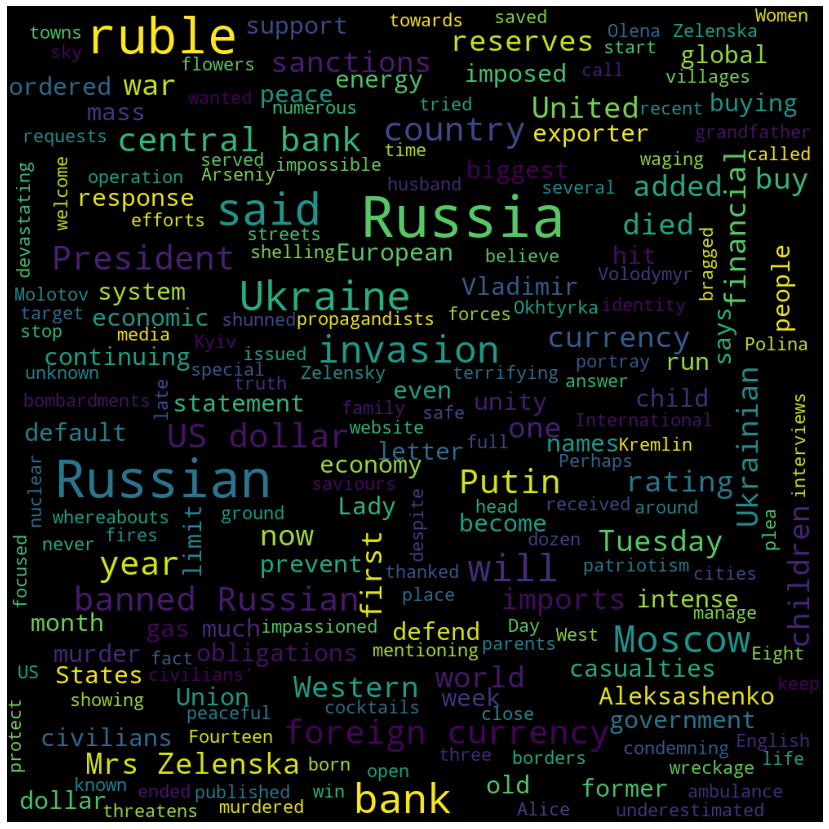

In [7]:
from PIL import Image

def create_masked_wc(data, ngram=False):
    wc = WordCloud(background_color="black",
                   max_words=200,
                   max_font_size=70,
                   contour_width=0,
                   width=1000,
                   height=1000)

    if ngram:
        wc.generate_from_frequencies(data)
    else:
        wc.generate(" ".join(data))


    # store to file
    # wc.to_file(generated_logo_path)

    # show
    plt.figure(figsize=(15,15))
    plt.imshow(wc)
    plt.axis("off")
    plt.show()

create_masked_wc(dataset)

In [8]:
# find all entities and plot

# add the trained sentencizer, although we already have the sentences
# let's do this for fun :-)
nlp.add_pipe('sentencizer') 

In [9]:
def flat_map(xs):
    ys = []
    for x in xs:
        ys.extend(x)
    return ys

def clean_sent(sent):
    escapes = ['\n', '\t', '\r']
    def valid(tok):
        return tok not in escapes
    for e in escapes:
        sent = sent.replace(e, ' ')
    return sent

MIN_LEN = 20        
def get_sentences(data):
    sents = []
    for sent in data:
        # clean the raw text
        cleaned = clean_sent(sent).strip()
        
        # parse possible sub-sentences using spacy
        doc = nlp(cleaned)
        sub_sents = [s.text for s in doc.sents if len(s.text) > MIN_LEN]
        sents.append(sub_sents)
    return flat_map(sents)

In [10]:
sents = get_sentences(dataset)

In [11]:
def ent_info(idx, ent):
    return {
        "sent_idx": idx,
        "start": ent.start_char,
        "end": ent.end_char,
        "label": ent.label_
    }

In [12]:
from collections import defaultdict
ents = defaultdict(list)
only_ent_names = []
for idx, sent in enumerate(sents):
    doc = nlp(sent)
    for ent in doc.ents:
        ents[str(ent).lower()].append(ent_info(idx, ent))
        only_ent_names.append(str(ent))

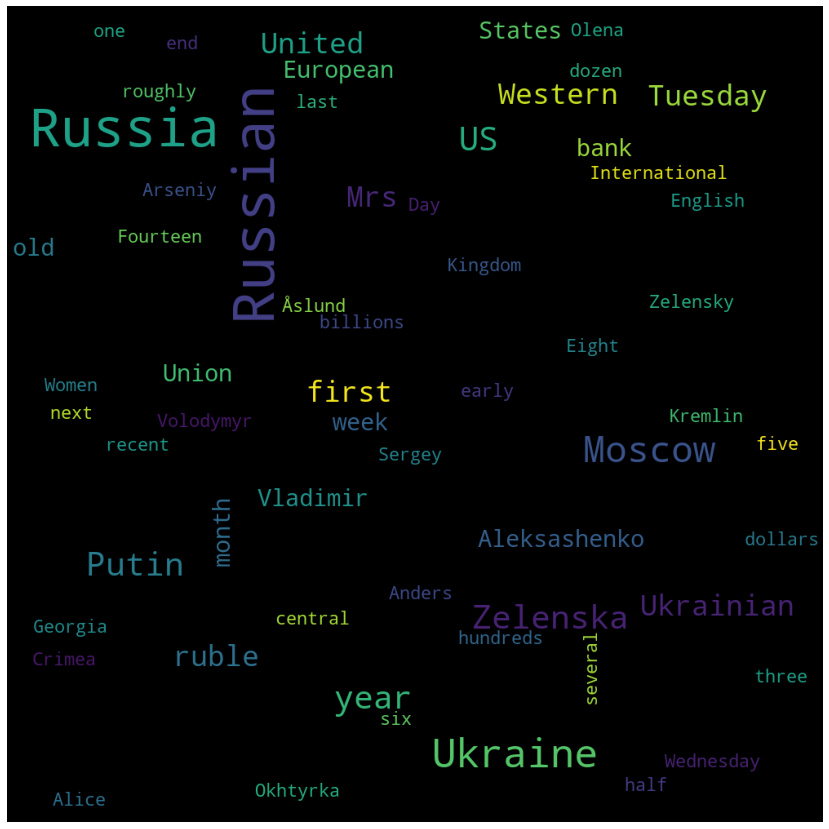

In [13]:
create_masked_wc(only_ent_names)

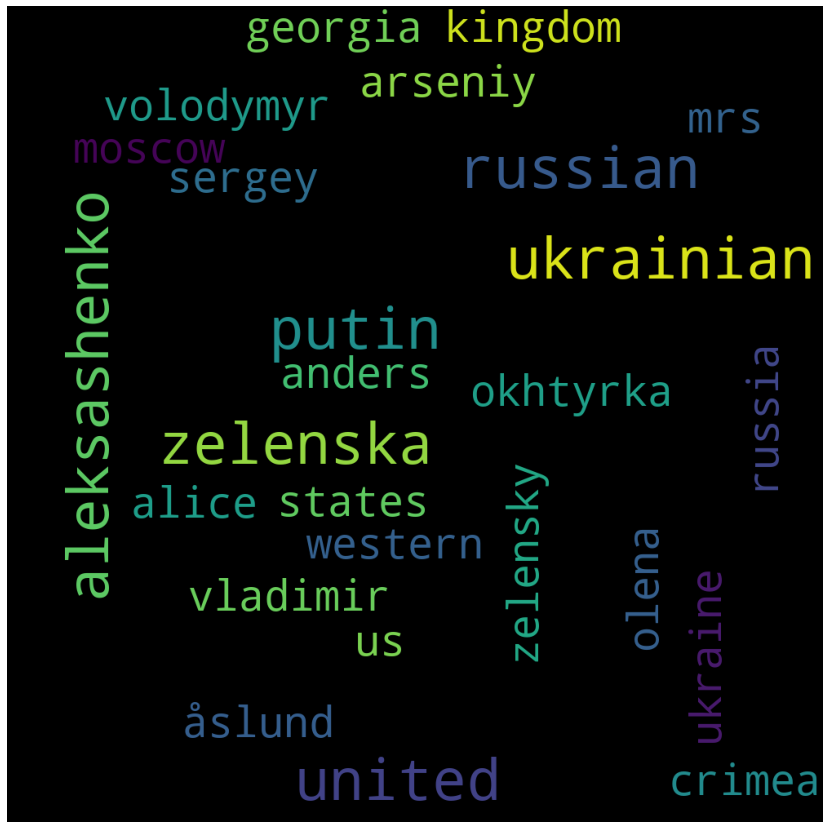

In [14]:
# filter out non-person/gpe/NORP ents
filtered_ents = []
for k, v in ents.items():
    if v[0]["label"] in ["PERSON", "GPE", "NORP"]:
        filtered_ents.append(k)
create_masked_wc(filtered_ents)
# note that NORP = Nationalities or religious or political groups